# Detectron2: Fishial 


## Import dependences

In [115]:
import detectron2
from detectron2.data import detection_utils as utils
from detectron2.utils.logger import setup_logger
# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

import random
import cv2
from matplotlib import pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

plt.rcParams["figure.figsize"] = (30,20)

Before we can start training our model we need to download some dataset. We use our dataset which we put to google drive and unpacking on googlecolab VM

Register our dataset to detectron2 as a COCO formate

In [99]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
from detectron2.data.datasets import register_coco_instances
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.data import MetadataCatalog, DatasetCatalog
import cv2
        
# write a function that loads the dataset into detectron2's standard format
def get_dataset_dicts(img_dir, state):
    json_file = "fishial_collection_correct.json"
    with open(json_file) as f:
        data = json.load(f)
        
    bodyes_shapes_ids = []
    for i in data['categories']:
        if i['name'] == 'General body shape':
            bodyes_shapes_ids.append(int(i['id']))

    dataset_dicts = []
    
    img_dir = os.path.join(img_dir, state)
    
    for i in range(len(data['images'])):
        if 'train_data' in data['images'][i]:
            state_json = 'Train' if data['images'][i]['train_data'] else 'Test'
            
            if state != state_json:
                continue
            
            record = {}
            filename = os.path.join(img_dir, data['images'][i]['file_name'])
            width, height = cv2.imread(filename).shape[:2]        
            record["file_name"] = filename
            record["height"] = width 
            record["width"] = height
            record["image_id"] = i
            
            objs = []
        
            for ann in data['annotations']:
                if 'segmentation' in ann and ann['image_id'] == data['images'][i]['id'] and ann['category_id'] in bodyes_shapes_ids:
                    px = []
                    py = []
                    for z in range(int(len(ann['segmentation'][0]) / 2)):
                        px.append(ann['segmentation'][0][z * 2])
                        py.append(ann['segmentation'][0][z * 2 + 1])

                    obj = {
                        "bbox": [np.min(px).tolist(), np.min(py).tolist(), np.max(px).tolist(), np.max(py).tolist()],
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "segmentation": ann['segmentation'],
                        "category_id": 0,
                        "iscrowd": 0
                    }
                    objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
    return dataset_dicts


In [117]:
# for d in ["Train", "Test"]:
#     DatasetCatalog.register("fishial_" + d, lambda d=d: get_dataset_dicts("fishial_collection", d))
#     MetadataCatalog.get("fishial_" + d).set(thing_classes=["fish"], evaluator_type="coco")
balloon_metadata = MetadataCatalog.get("fishial_Train")
balloon_metadata = MetadataCatalog.get("fishial_Test")

In [129]:
from utils import custom_config
from trainer import Trainer

In [132]:
cfg = custom_config()
trainer = Trainer(cfg)

# train_data_loader = trainer.build_train_loader(cfg)
# data_iter = iter(train_data_loader)
# batch = next(data_iter)

NameError: name 'get_cfg' is not defined

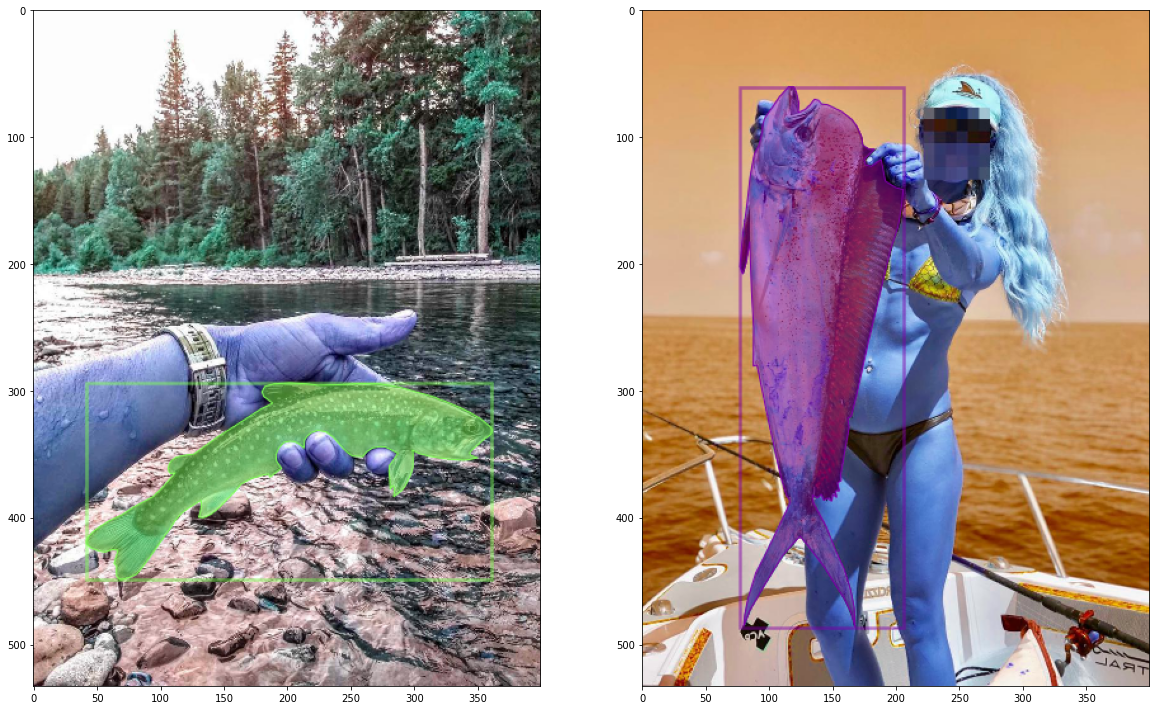

In [127]:
# visualization

rows, cols = 1, 2
plt.figure(figsize=(20,20))

for i, per_image in enumerate(batch[:9]):
    
    plt.subplot(rows, cols, i+1)
    
    # Pytorch tensor is in (C, H, W) format
    img = per_image["image"].permute(1, 2, 0).cpu().detach().numpy()
    img = utils.convert_image_to_rgb(img, cfg.INPUT.FORMAT)

    visualizer = Visualizer(img, metadata=balloon_metadata, scale=0.5)

    target_fields = per_image["instances"].get_fields()
    labels = None
    vis = visualizer.overlay_instances(
        labels=labels,
        boxes=target_fields.get("gt_boxes", None),
        masks=target_fields.get("gt_masks", None),
        keypoints=target_fields.get("gt_keypoints", None),
    )
    plt.imshow(vis.get_image()[:, :, ::-1])

In [111]:
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])

NameError: name 'dataset_dicts' is not defined

Config train pipline

In [4]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("fishial_Train",)
cfg.DATASETS.TEST = ("fishial_Test", )
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "output/model_0039999.pth"  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 50000
cfg.OUTPUT_DIR = "./output_eval/"
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)
cfg.TEST.EVAL_PERIOD = 3000

In [7]:
print(cfg.dump())

CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - fishial_Test
  TRAIN:
  - fishial_Train
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: false
    SIZE:
    - 0.9
    - 0.9
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN:
  - 640
  - 672
  - 704
  - 736
  - 768
  - 800
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES:
    - - -90
      - 0
      - 90
    ASPECT_RATIOS:
    - - 0.5
      - 1.0
      - 2.0
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES:
    - - 32
    - - 64
    - - 128
    - - 256
    - - 512
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet

In [5]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load()
trainer.model.eval()
evaluator = COCOEvaluator("fishial_Test", ("bbox", "segm"), False, output_dir="./output_eval/")
val_loader = build_detection_test_loader(cfg, "fishial_Test")
dict_sd = inference_on_dataset(trainer.model, val_loader, evaluator)

[10/27 06:35:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[10/27 06:37:04 d2.data.build]: Removed 0 images with no usable annotations. 7682 images left.
[10/27 06:37:05 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    fish    | 11953        |
|            |              |
[10/27 06:37:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[10/27 06:37:05 d2.data.build]: Using training sampler TrainingSampler
[10/27 06:37:05 d2.data.common]: Serializing 7682 elements to byte tensors and concatenating them all ...
[10/27 06:37:05 d2.data.common]: Serialized dataset takes 15.01 MiB
[10/27 06:37:05 d2.evaluation.coco_evaluation]: Trying to convert 'fishial_Test' to COCO format ...
WARNING [10/27 06:37:05 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output_eval/fishial_Test_coco_format.json'. 

/home/codahead/anaconda3/envs/d2go-env/lib/python3.6/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/codahead/anaconda3/envs/d2go-env/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/27 06:37:24 d2.evaluation.evaluator]: Inference done 11/1920. Dataloading: 0.0006 s/iter. Inference: 0.0804 s/iter. Eval: 0.0049 s/iter. Total: 0.0859 s/iter. ETA=0:02:43
[10/27 06:37:29 d2.evaluation.evaluator]: Inference done 64/1920. Dataloading: 0.0007 s/iter. Inference: 0.0840 s/iter. Eval: 0.0098 s/iter. Total: 0.0945 s/iter. ETA=0:02:55
[10/27 06:37:34 d2.evaluation.evaluator]: Inference done 117/1920. Dataloading: 0.0008 s/iter. Inference: 0.0839 s/iter. Eval: 0.0099 s/iter. Total: 0.0947 s/iter. ETA=0:02:50
[10/27 06:37:39 d2.evaluation.evaluator]: Inference done 174/1920. Dataloading: 0.0008 s/iter. Inference: 0.0835 s/iter. Eval: 0.0083 s/iter. Total: 0.0927 s/iter. ETA=0:02:41
[10/27 06:37:45 d2.evaluation.evaluator]: Inference done 229/1920. Dataloading: 0.0008 s/iter. Inference: 0.0847 s/iter. Eval: 0.0071 s/iter. Total: 0.0926 s/iter. ETA=0:02:36
[10/27 06:37:50 d2.evaluation.evaluator]: Inference done 282/1920. Dataloading: 0.0008 s/iter. Inference: 0.0850 s/iter. E

Loading and preparing results...
DONE (t=0.09s)
creating index...
index created!
[10/27 06:40:16 d2.evaluation.fast_eval_api]: Evaluate annotation type *segm*
[10/27 06:40:16 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.42 seconds.
[10/27 06:40:16 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[10/27 06:40:16 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.743
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.904
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.851
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.540
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.794
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.568
 Avera

SyntaxError: invalid syntax (<ipython-input-21-67a27b3f68be>, line 3)

[10/26 10:54:14 d2.evaluation.coco_evaluation]: Evaluation results for segm: 
|   AP   |  AP50  |  AP75  |  APs   |  APm   |  APl   |
|:------:|:------:|:------:|:------:|:------:|:------:|
| 71.042 | 89.093 | 82.463 | 23.125 | 48.511 | 76.815 |



In [ ]:
dataset_dicts = get_dataset_dicts("fishial_collection", 'Test')

##Creating a predictor object.

In [23]:
from detectron2.utils.visualizer import ColorMode
import random
import urllib
import os
cfg.MODEL.WEIGHTS = "output/model_0049999.pth"  # Let training initialize from model zoo
predictor = DefaultPredictor(cfg)

###Visualization for Instance segmentation Model

fishial_collection/Test/00008565.jpg
--- 0.10085701942443848 seconds ---


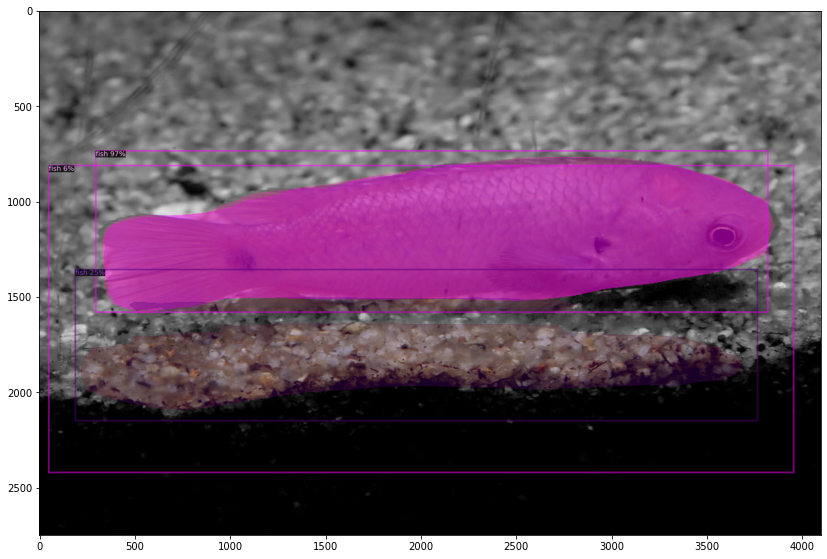

fishial_collection/Test/00010475.jpeg
--- 0.06938481330871582 seconds ---


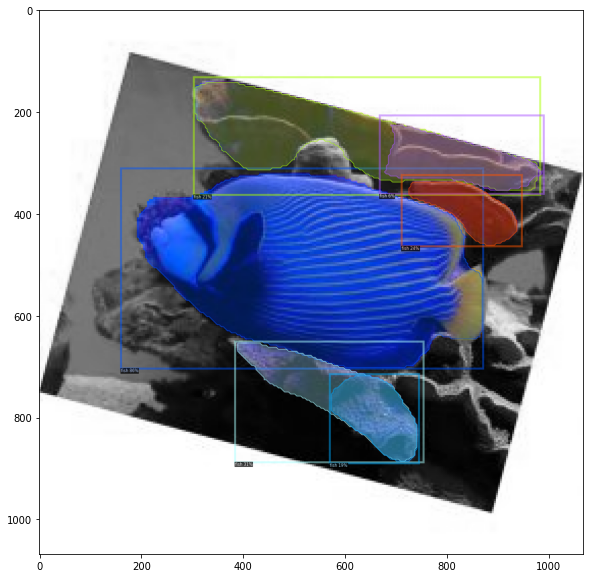

fishial_collection/Test/00030683.jpg
--- 0.09172725677490234 seconds ---


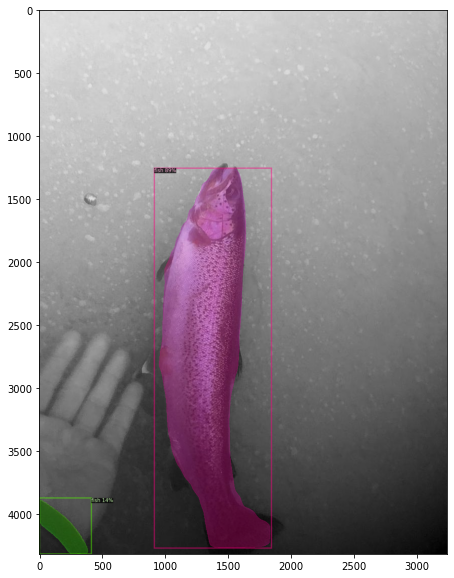

fishial_collection/Test/00004704.jpg
--- 0.09801626205444336 seconds ---


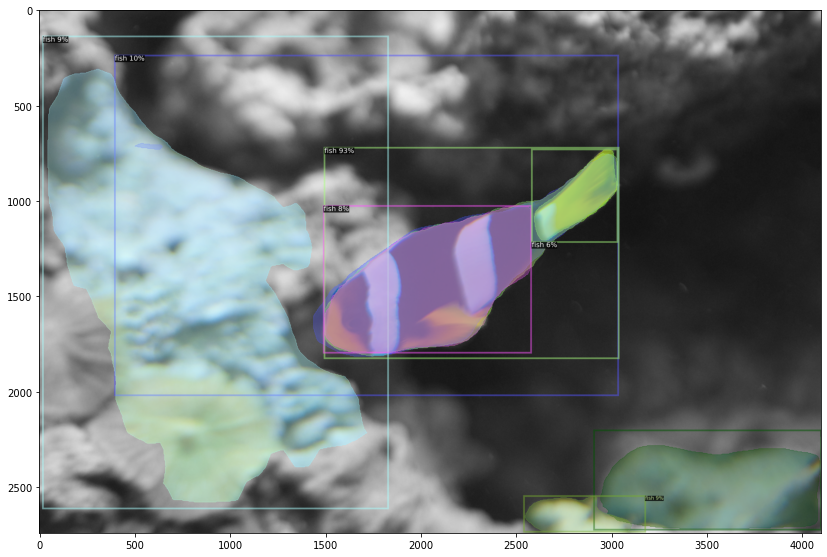

fishial_collection/Test/00030408.jpg
--- 0.09195637702941895 seconds ---


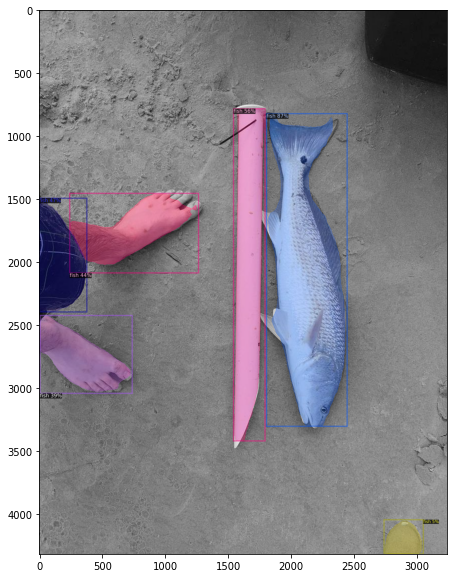

In [21]:

import time
for d in random.sample(dataset_dicts, 5):
    print(d['file_name'])
    im = cv2.imread(d['file_name'])
    start_time = time.time()
    outputs = predictor(im)
    print("--- %s seconds ---" % (time.time() - start_time))
    v = Visualizer(im[:, :, ::-1],
                   MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), 
                   scale=4, 
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

1


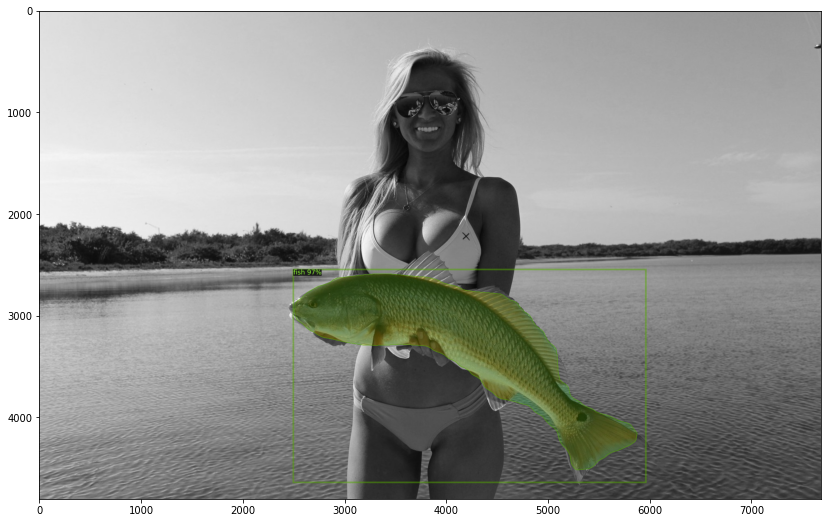

In [22]:
import urllib
urllib.request.urlretrieve("https://krasivosti.pro/uploads/posts/2021-04/1618441694_15-krasivosti_pro-p-ribak-s-riboi-ribi-krasivo-foto-17.jpg", "00000001.jpg")
im = cv2.imread( "00000001.jpg")
outputs = predictor(im)
print(len(outputs['instances']))
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=4, 
               instance_mode=ColorMode.IMAGE_BW)   # remove the colors of unsegmented pixels
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

1


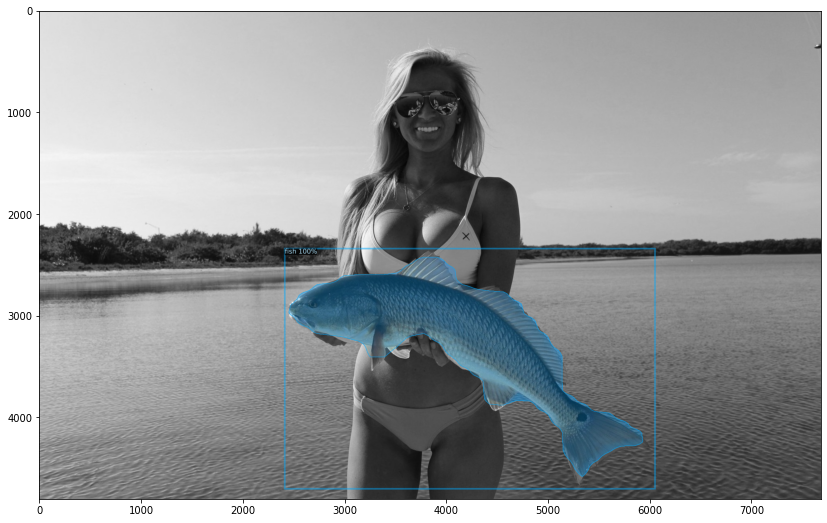

In [24]:
import urllib
urllib.request.urlretrieve("https://krasivosti.pro/uploads/posts/2021-04/1618441694_15-krasivosti_pro-p-ribak-s-riboi-ribi-krasivo-foto-17.jpg", "00000001.jpg")
im = cv2.imread( "00000001.jpg")
outputs = predictor(im)
print(len(outputs['instances']))
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=4, 
               instance_mode=ColorMode.IMAGE_BW)   # remove the colors of unsegmented pixels
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

###For Bouding box

In [ ]:
dataset_dicts = get_dataset_dicts("fishial/val")
for d in random.sample(dataset_dicts, 3):
    urllib.request.urlretrieve("https://www.aqvium.ru/images/blog/2016-11-08-glofish/Origins-glofish.jpg", "00000001.jpg")
    im = cv2.imread(d['file_name'])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=balloon_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
urllib.request.urlretrieve("https://www.aqvium.ru/images/blog/2016-11-08-glofish/Origins-glofish.jpg", "00000001.jpg")
im = cv2.imread(d['file_name'])
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata=balloon_metadata, scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

If we want we can also display the training process through Tensorboard.

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
import json
import matplotlib.pyplot as plt

experiment_folder = './output'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics], 
    [x['total_loss'] for x in experiment_metrics])
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
plt.legend(['total_loss', 'validation_loss'], loc='upper left')
plt.show()

In [ ]:
!rm -rf output/

In [ ]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("H3UwLsvACl4", width=500)
display(video)

In [ ]:
# Install dependencies, download the video, and crop 5 seconds for processing
!pip install youtube-dl
!pip uninstall -y opencv-python opencv-contrib-python
!apt install python3-opencv  # the one pre-installed have some issues
!youtube-dl https://www.youtube.com/watch?v=H3UwLsvACl4 -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:06 -c:v copy video-clip.mp4

In [ ]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes)
# Using a model trained on COCO dataset
# !git clone https://github.com/facebookresearch/detectron2
!python detectron2/demo/demo.py --config-file detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.1 --output video-output.mkv \
  --opts MODEL.WEIGHTS output/model_final.pth

In [ ]:
# Download the results
from google.colab import files
files.download('via_region_data.json')

In [ ]:
def get_format_dict(title, area, array_x, array_y, filename):
    return {
            title: {
                "fileref": "",
                "size": area,
                "filename": filename,
                "base64_img_data": "",
                "verified": False,
                "correct": False,
                "file_attributes": {
                },
                "regions": {
                    "0": {
                        "shape_attributes": {
                            "name": "polygon",
                            "all_points_x": array_x,
                            "all_points_y": array_y
                        },
                        "region_attributes": {

                        }
                    }
                }
            }
        }

##Create polygons dictionary
this code for create synthetic dataset

In [17]:
import os, json
import cv2
import pandas as pd
from shutil import copyfile
import re
from imantics import Polygons, Mask
import warnings

path_img = r'parsing'
list_path_img = [os.path.basename(i) for i in os.listdir(path_img)]
anotation_dict = {}
for idx, img_name in enumerate(list_path_img):
  print("Score: {}".format(len(list_path_img) - idx), len(anotation_dict))
  im = cv2.imread(os.path.join(path_img, img_name))
  w,h,_ = im.shape
  outputs = predictor(im)
  for z in range(len(outputs['instances'])):
    masks = np.array(outputs['instances'].get('pred_masks')[z].to('cpu'))
    polygons = Mask(masks).polygons()
    x_array = []
    y_array = []
    for i in polygons.points[0]:
      x_array.append(int(i[0]))
      y_array.append(int(i[1]))

    anotation_dict.update(get_format_dict(
        img_name+"_main_"+str(z),
        w*h,
        x_array,
        y_array,
        img_name))
print(|   AP   |  AP50  |  AP75  |  APs   |  APm   |  APl   |
|:------:|:------:|:------:|:------:|:------:|:------:|
| 74.369 | 91.183 | 85.507 | 28.339 | 54.211 | 79.405 |)
with open('via_region_data.json', 'w') as fp:
    json.dump(anotation_dict, fp)

SyntaxError: invalid syntax (<ipython-input-17-e7ef10f07ad4>, line 32)

In [7]:
print(cfg.dump())

CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST: fishial_Test
  TRAIN:
  - fishial_Train
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: false
    SIZE:
    - 0.9
    - 0.9
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN:
  - 640
  - 672
  - 704
  - 736
  - 768
  - 800
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES:
    - - -90
      - 0
      - 90
    ASPECT_RATIOS:
    - - 0.5
      - 1.0
      - 2.0
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES:
    - - 32
    - - 64
    - - 128
    - - 256
    - - 512
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn

In [ ]:
'Model model_0004999.pth',
 'segm', {'AP': 71.04204623117492, 'AP50': 89.0925970588023, 'AP75': 82.46337376053368, 
          'APs': 23.125076587151675, 'APm': 48.10500338842036, 'APl': 76.8154729012781})])], 

'Model model_0009999
('segm', {'AP': 70.5977483758233, 'AP50': 90.0157460715852, 'AP75': 83.80336098985133, 
          'APs': 29.62110307601359, 'APm': 52.19061902605725, 'APl': 77.84958932630462})])], 

14999
[10/26 12:03:14 d2.evaluation.coco_evaluation]: Evaluation results for segm:                                                                                                                    
|   AP   |  AP50  |  AP75  |  APs   |  APm   |  APl   |                                                                                                                                         
|:------:|:------:|:------:|:------:|:------:|:------:|                                                                                                                                         
| 73.559 | 90.683 | 84.409 | 28.442 | 53.248 | 78.704 |  

['Model model_0019999.pth']
[10/26 11:54:11 d2.evaluation.coco_evaluation]: Evaluation results for segm:
|   AP   |  AP50  |  AP75  |  APs   |  APm   |  APl   |
|:------:|:------:|:------:|:------:|:------:|:------:|
| 74.369 | 91.183 | 85.507 | 28.339 | 54.211 | 79.405 |

model_0024999 
[10/26 11:58:41 d2.evaluation.coco_evaluation]: Evaluation results for segm:                                                                                                                    
|   AP   |  AP50  |  AP75  |  APs   |  APm   |  APl   |                                                                                                                                         
|:------:|:------:|:------:|:------:|:------:|:------:|                                                                                                                                         
| 74.260 | 90.488 | 84.994 | 29.327 | 53.943 | 79.587 |  

['Model model_0034999.pth' ('segm', {'AP': 73.83524698704437, 'AP50': 90.365507226756, 'AP75': 84$
49940228707067, 'APs': 28.393289435747814, 'APm': 53.91910872764151, 'APl': 78.9582512708673})])], 

['Model model_0039999.pth']
[10/26 11:45:01 d2.evaluation.coco_evaluation]: Evaluation results for segm:                                                                                                                    
|   AP   |  AP50  |  AP75  |  APs   |  APm   |  APl   |                                                                                                                                         
|:------:|:------:|:------:|:------:|:------:|:------:|                                                                                                                                         
| 74.666 | 90.797 | 85.199 | 28.870 | 54.550 | 79.569 | 

['Model model_0044999.pth',
('segm', {
    'AP': 74.62379734117175, 'AP50': 90.91392693540843, 'AP75': 85.11703313118811, 
    'APs': 28.519473256691757, 'APm': 54.72246667156232, 'APl': 79.59746765611699})])], 

[['Model model_0049999.pth',
  'segm', {'AP': 73.92000258524286, 'AP50': 89.73263213019636, 'AP75': 84.58968032907983, 
           'APs': 29.333786651431026, 'APm': 54.220062179878056, 'APl': 79.21134398352417})])], 


['Model model_0059999.pth']
[10/26 11:49:39 d2.evaluation.coco_evaluation]: Evaluation results for segm:                                                                                                                    
|   AP   |  AP50  |  AP75  |  APs   |  APm   |  APl   |                                                                                                                                         
|:------:|:------:|:------:|:------:|:------:|:------:|                                                                                                                                         
| 65.469 | 85.742 | 78.881 | 26.184 | 41.219 | 71.235 | 




In [95]:
def buetifier_results(results):
    line = 70 * "="
    header = line + """\n|   AP   |  AP50  |  AP75  |  APs   |  APm   |  APl   |  Name \n|:------:|:------:|:------:|:------:|:------:|:------:|:------:"""
    for result in results:
        header += """\n| {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} |{}""".format(
            result[1]['segm']['AP'],
            result[1]['segm']['AP50'],
            result[1]['segm']['AP75'],
            result[1]['segm']['APs'],
            result[1]['segm']['APm'],
            result[1]['segm']['APl'],
            result[0])
    return header + "\n" + line

def save_to_json(results, mypath):
    json_file = {}
    for result in results:
        single_rec = {
            result[0]: {
                'AP': result[1]['segm']['AP'],
                'AP50': result[1]['segm']['AP50'],
                'AP75': result[1]['segm']['AP75'],
                'APs': result[1]['segm']['APs'],
                'APl': result[1]['segm']['APl']}}
        json_file.update(single_rec)
    with open(os.path.join(mypath, 'evalute_scores.json'), 'w') as f:
        json.dump(json_file, f)
    return json_file

In [90]:
test_array = []
test_array.append(["Name 1 ", dict_sd])
test_array.append(["Name 2 ", dict_sd])
test_array.append(["Name 3 ", dict_sd])
test_array.append(["Name 4 ", dict_sd])



print(buetifier_results(test_array))

|   AP   |  AP50  |  AP75  |  APs   |  APm   |  APl   |  Name 
|:------:|:------:|:------:|:------:|:------:|:------:|:------:
| 74.337 | 90.404 | 85.146 | 29.159 | 54.001 | 79.440 |Name 1 
| 74.337 | 90.404 | 85.146 | 29.159 | 54.001 | 79.440 |Name 2 
| 74.337 | 90.404 | 85.146 | 29.159 | 54.001 | 79.440 |Name 3 
| 74.337 | 90.404 | 85.146 | 29.159 | 54.001 | 79.440 |Name 4 


In [97]:
print(70 * "=")
print(save_to_json(test_array, 'output'))
print(70 * "=")

{'Name 1 ': {'AP': 74.33719453188056, 'AP50': 90.40380487986013, 'AP75': 85.14568047196627, 'APs': 29.158745450101094, 'APl': 79.4395549942534}, 'Name 2 ': {'AP': 74.33719453188056, 'AP50': 90.40380487986013, 'AP75': 85.14568047196627, 'APs': 29.158745450101094, 'APl': 79.4395549942534}, 'Name 3 ': {'AP': 74.33719453188056, 'AP50': 90.40380487986013, 'AP75': 85.14568047196627, 'APs': 29.158745450101094, 'APl': 79.4395549942534}, 'Name 4 ': {'AP': 74.33719453188056, 'AP50': 90.40380487986013, 'AP75': 85.14568047196627, 'APs': 29.158745450101094, 'APl': 79.4395549942534}}


In [36]:
print("%.2f %.2f %.2f " % 2.3, 2.3, 2.3)

TypeError: not enough arguments for format string